## Import Libraries and Load Data

In [1]:
from prophet import Prophet
import modules.preprocessing as prep
import modules.modeling as mdl
import modules.evaluation as ev
import os

In [2]:
# Load dataset
df = prep.load_dataset('../data/SN_d_tot_V2.0.csv')
df

year  month  day  predicted_sunspots
0      1818      1    1                  -1
1      1818      1    2                  -1
2      1818      1    3                  -1
3      1818      1    4                  -1
4      1818      1    5                  -1
...     ...    ...  ...                 ...
74625  2022      4   26                 132
74626  2022      4   27                 132
74627  2022      4   28                 135
74628  2022      4   29                 107
74629  2022      4   30                  51

[74630 rows x 4 columns]

In [3]:
# Create formatted dataframe for usage in Prophet and extract periodicity for forecasting
periodic_df, periodicity = prep.create_periodic_dataframe(df)
periodic_df

ds    y
0     1818-01-01   -1
1     1818-01-02   -1
2     1818-01-03   -1
3     1818-01-04   -1
4     1818-01-05   -1
...          ...  ...
74625 2022-04-26  132
74626 2022-04-27  132
74627 2022-04-28  135
74628 2022-04-29  107
74629 2022-04-30   51

[74630 rows x 2 columns]

In [4]:
# Define number of future periods to forecast and base paths for models and forecasts
future_periods = [100, 200, 365]
models_base_path = os.path.join('..', 'models', 'daily')
forecasts_base_path = os.path.join('..', 'forecasts', 'daily')

## Base Model Statistics

In [5]:
# Define save paths
model_name = 'base_daily'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

# Define parameters and fit model
base_params = {'df': periodic_df, 'func': Prophet}
func_params = {}
seasonality_params = {}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

In [6]:
# Load model and forecast
model = ev.load_pickle(model_path)
forecast = ev.load_pickle(forecast_path)

Pickled object at ../models/daily/base_daily.pickle loaded successfully.
Pickled object at ../forecasts/daily/base_daily.pickle loaded successfully.


There are three metrics used to evaluate the health of the model: mean average error (MAE), mean average percentage error (MAPE) and $R^2$ score. MAE measures the raw size of the errors, MAPE measures the percentage error, and $R^2$ measures the amount of variance captured by the model.

In [7]:
# Calculate model metrics
ev.calculate_errors(periodic_df, forecast[0])

mae      mape      r2
Model Errors  56.713345  1.132964  0.1499

The base model fails to capture any of the seasonality present in the data, leading to an overly simplistic and highly underfitted model.

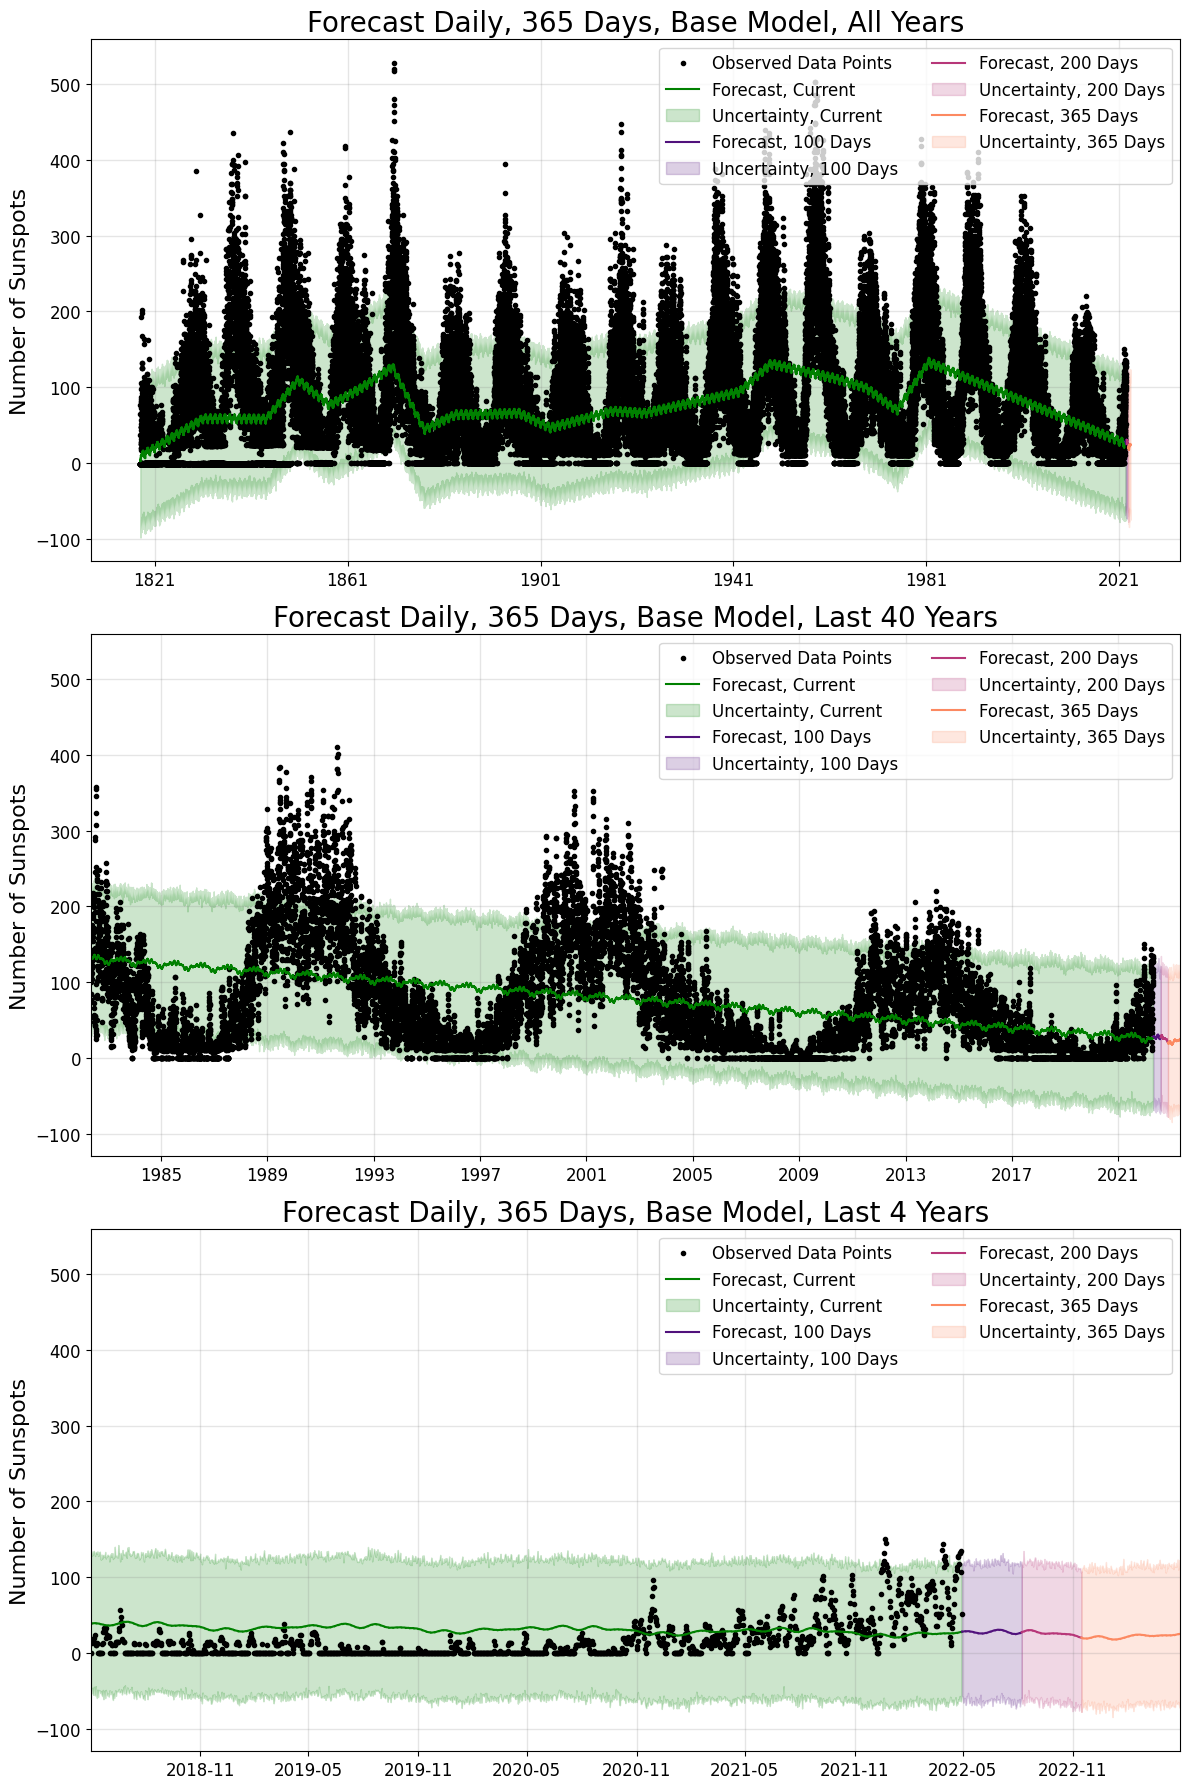

In [8]:
# Define plotting parameters
plot_params = {
    'model': model, 'current_fc': forecast[0], 'future_fc': forecast[1],
    'prior_periods': [None, 40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles':[
        'Forecast Daily, 365 Days, Base Model, All Years',
        'Forecast Daily, 365 Days, Base Model, Last 40 Years',
        'Forecast Daily, 365 Days, Base Model, Last 4 Years'
    ]}

# Plot model across different time windows
ev.plot_multi_timeframes(**plot_params);

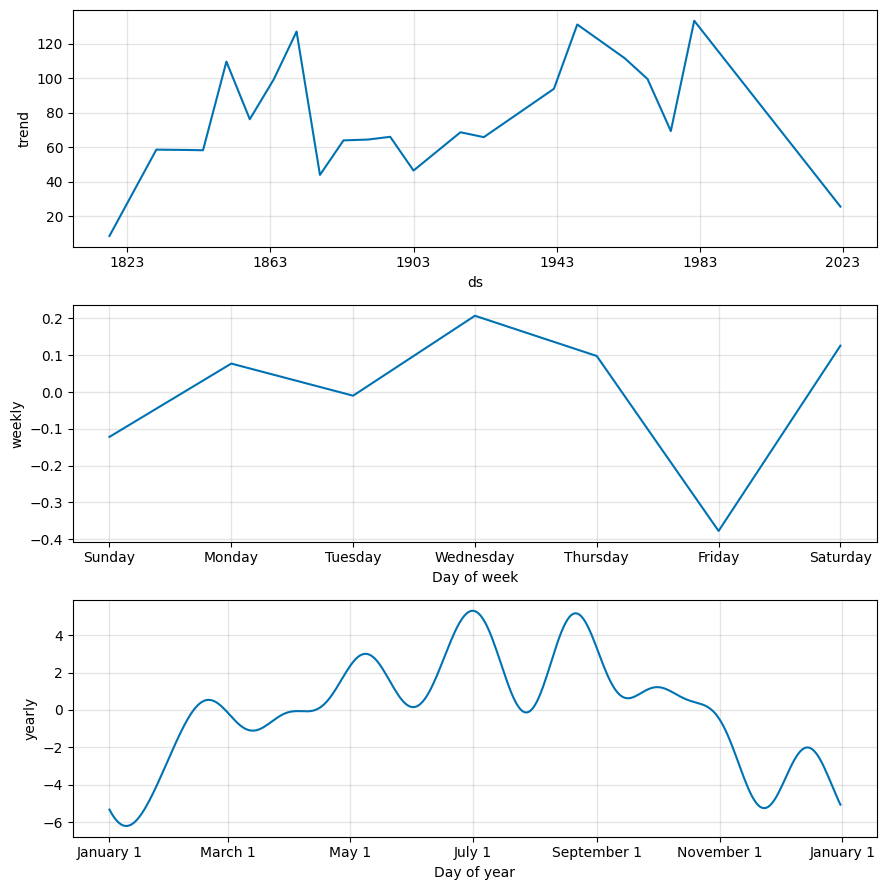

In [9]:
# Investigate base model components
model.plot_components(forecast[0], uncertainty = False);

## Model Tuning

Naming scheme:\
{sampling frequency}\_\_s-{seaonality_params}\_\_-g-{growth_type}\_\_-cp-{changepoint_prior}\_\_cn-{num_changepoints}.pickle\
Multiple params of same type separated by single _\
s = custom seasonality in form KyPf where K is the number of years and P is the Fourier Order\
g = growth type, default linear\
cp = changepoint prior frequency as a percent, default 5%\
cn = number of changepoints, default 25

## Tuning Seasonality

### 11 Years Custom Seasonality, Differing Fourier Orders

It is well documented that the solar magnetic has a half-cycle of approximately 11 years, where the magnetic poles of the Sun reverse and lead to a new cycle of sunspot activity. This translates to approximately 4017.75 days (~365.25 days per year). Different levels of Fourier Order allow the model the change more frequently (predict a less smooth and lower bias function) but can lead to overfitting (high variance changes), while also increasing model complexity in terms of calculation time. The Prophet documentation states that they use a default Fourier order of 10 for yearly data.

In [10]:
# Test on Fourier Order 5, 10, 20, 40, and 120
fourier_orders = [5, 10, 20, 40, 120]
model_names = [f'daily__s-11y{x}f__g-linear__cp-5__cn-25' for x in fourier_orders]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]

base_params = {'df': periodic_df, 'func': Prophet}
func_params = {'weekly_seasonality': False, 'yearly_seasonality': False}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     seasonality_params = {f'11 Year, Fourier {fourier_orders[i]}':
#                               {'period': 4017.75, 'fourier_order': fourier_orders[i]}}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

In [11]:
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]

Pickled object at ../models/daily/daily__s-11y5f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y10f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y40f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y120f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y5f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y10f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y40f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y120f__g-linear__cp-5__cn-25.pic

Observe that the mean errors continue to decrease for higher Fourier orders, and the $R^2$ value increases. This means that a better fit is achieved by increasing the Fourier order; however, the improvement is very small for a large increase in model complexity. The improvement difference between Fourier Order 5 and Fourier Order 120 in MAE is ~0.17 when the scale is in the 10s or 100s, and only increases $R^2$ by 0.006 while having 24x more Fourier components.

In [12]:
obs_preds_names = [(periodic_df, forecasts[i][0], list(models[i].seasonalities.keys())[0])
                   for i in range(len(forecasts))]

ev.multi_model_errors(obs_preds_names)

mae      mape        r2
11 Year, Fourier 5    45.445435  0.847931  0.405885
11 Year, Fourier 10   45.484686  0.849175  0.405251
11 Year, Fourier 20   45.423222  0.848183  0.407485
11 Year, Fourier 40   45.385132  0.847838  0.408803
11 Year, Fourier 120  45.279609  0.846332  0.411943

The Fourier Order 120 model makes much less smooth predictions but are ultimately similar to the Fourier Order 20 model. To keep the model simple and reduce calculation time, all further models will use Fourier Order 20.

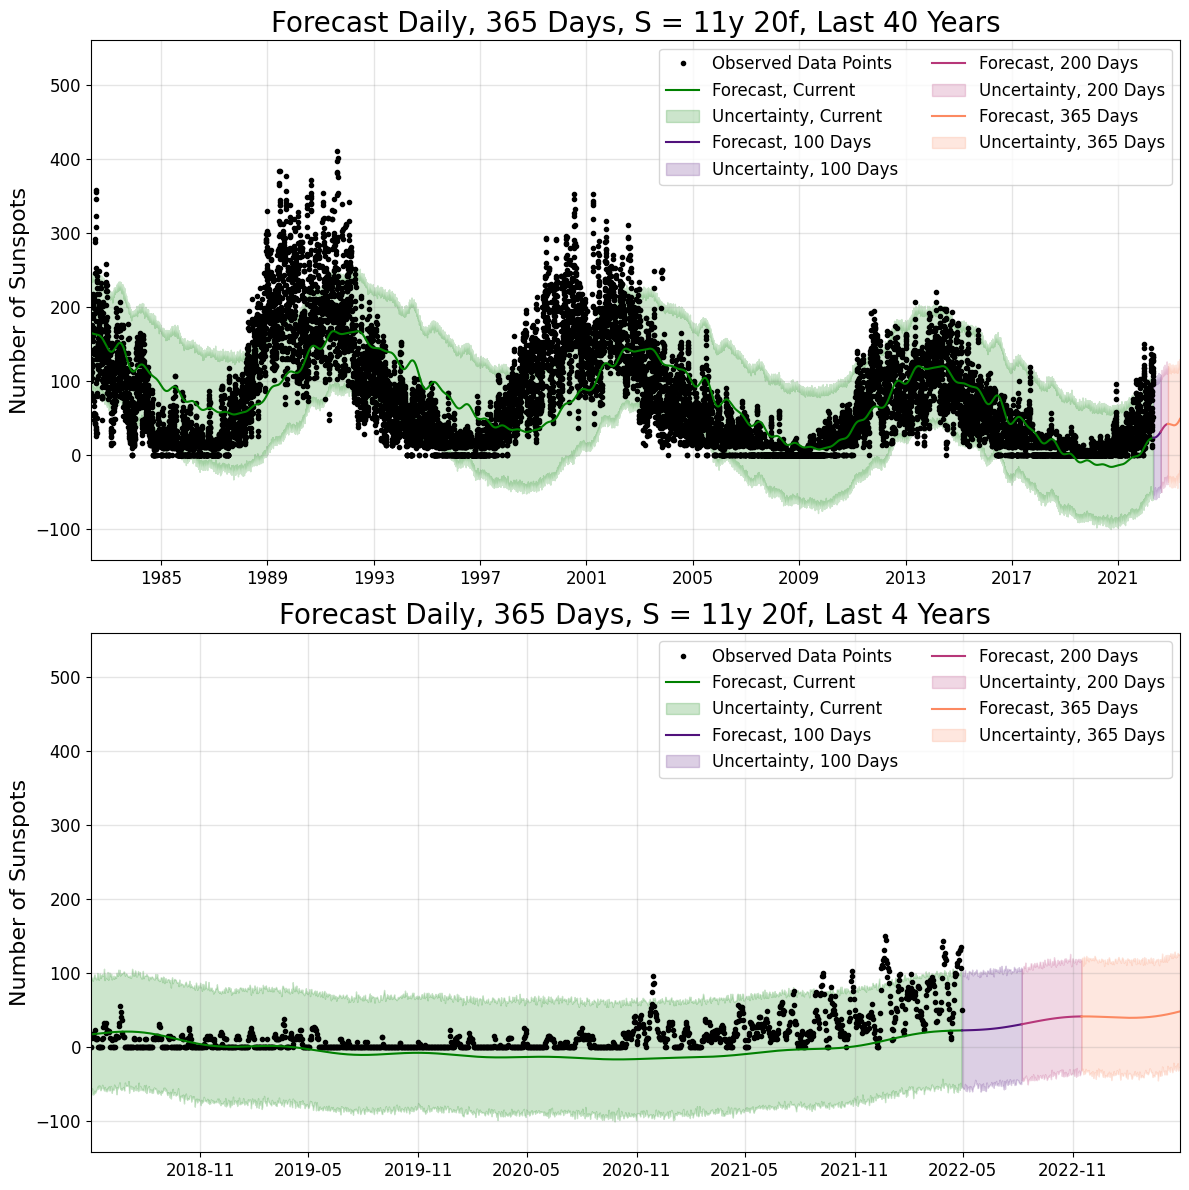

In [13]:
# Plot Fourier Order 20 Predictions
idx = 2

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, S = 11y 20f, Last 40 Years',
        'Forecast Daily, 365 Days, S = 11y 20f, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

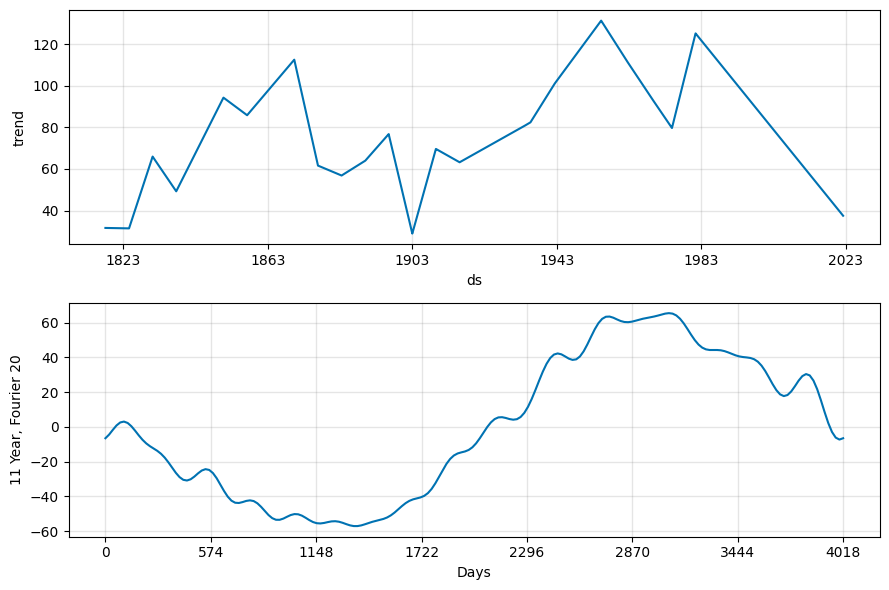

In [14]:
# Components of Fourier Order 20
models[idx].plot_components(forecasts[idx][0], uncertainty = False);

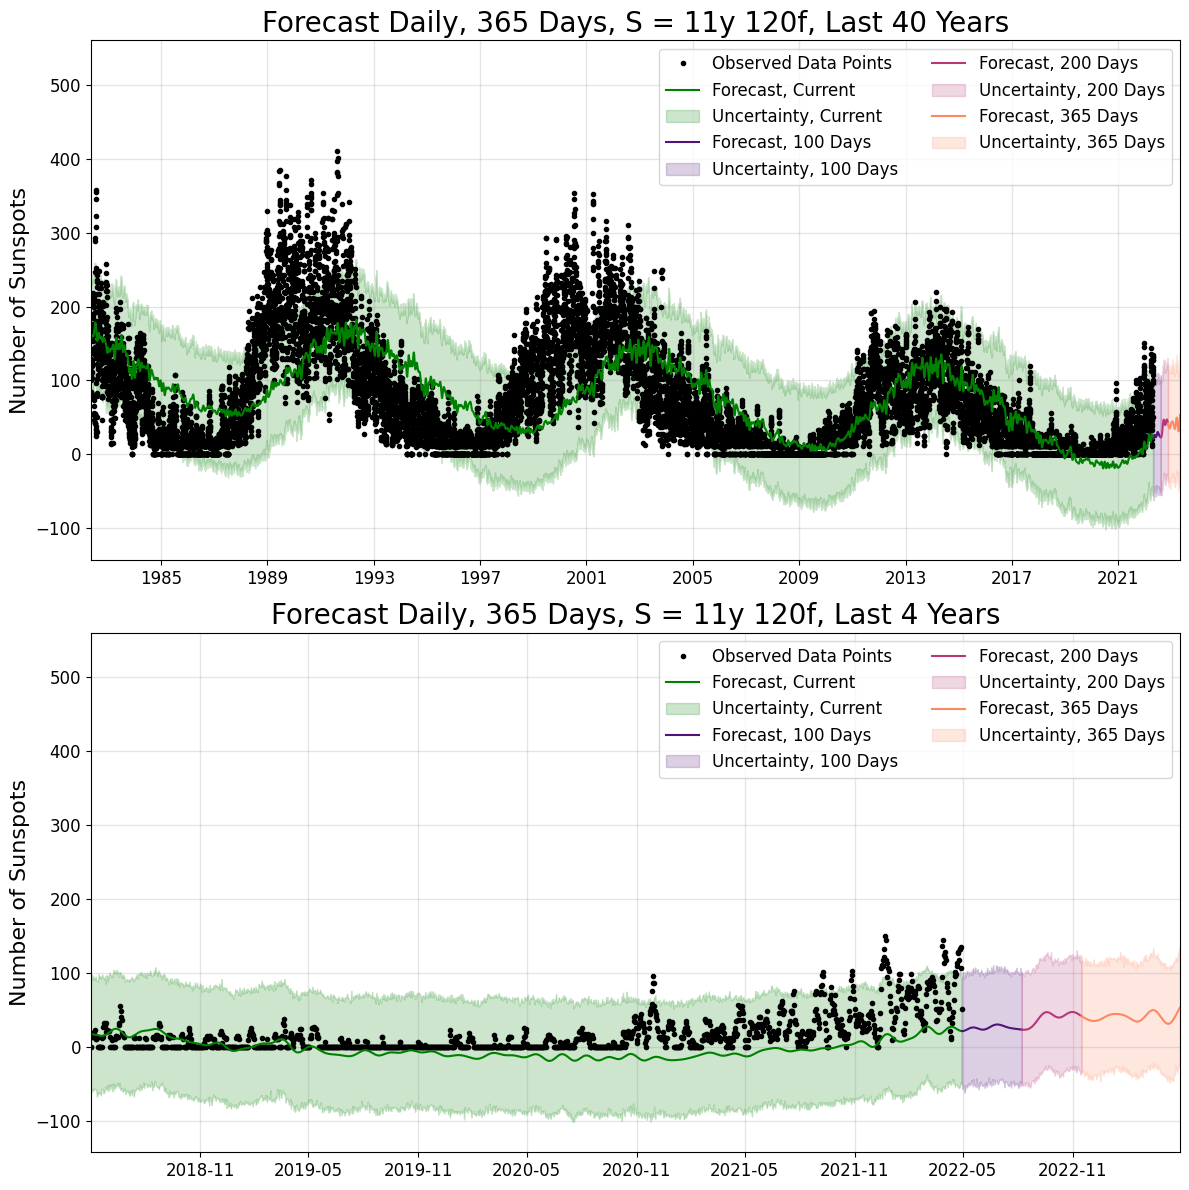

In [15]:
# Plot Fourier Order 120 Predictions
idx = -1

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, S = 11y 120f, Last 40 Years',
        'Forecast Daily, 365 Days, S = 11y 120f, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

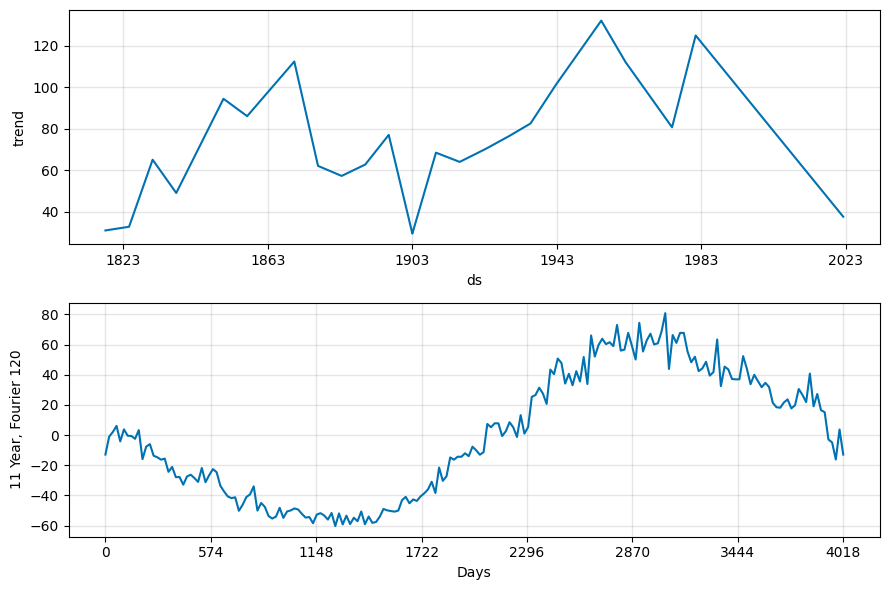

In [16]:
# Components of Fourier Order 120
models[idx].plot_components(forecasts[idx][0], uncertainty = False);

### 22 Years Custom Seasonality with and without 11 Year Custom Seasonality

In theory, the full solar magnetic cycle is 22 years, not 11 years. To test this, two 22-year seasonality models were tested (one with the 11 year seasonality, one without).

In [17]:
# Fit models on seasonality of 22 years with Fourier Order 20
# and on seasonalities of 22 years and 11 years with Fourier Order 20
model_names = [
    'daily__s-22y20f__g-linear__cp-5__cn-25',
    'daily__s-22y20f_11y20f__g-linear__cp-5__cn-25'
              ]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]

base_params = {'df': periodic_df, 'func': Prophet}
func_params = {'weekly_seasonality': False, 'yearly_seasonality': False}
seasonality_params = {'22 Year, Fourier 20': {'period': 8035.5, 'fourier_order': 20}}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     if i == 1:
#         seasonality_params['11 Year, Fourier 20'] = {'period': 4017.75, 'fourier_order': 20}
        
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

In [18]:
half_cycle_name = 'daily__s-11y20f__g-linear__cp-5__cn-25'
half_cycle_model_path = os.path.join(models_base_path, half_cycle_name + '.pickle')
half_cycle_forecast_path = os.path.join(forecasts_base_path, half_cycle_name + '.pickle')

models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(half_cycle_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(half_cycle_forecast_path))

Pickled object at ../models/daily/daily__s-22y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-22y20f_11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-22y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-22y20f_11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.


The model with only 22 year seasonality performs only slightly better than the 11 year seasonality model. The model with both seasonalities outperforms the models with only one seasonality, but not by very much - the improvement over the 11 year seasonality is worse than the improvement gained from increasing the Fourier Order of the 11 year seasonality model.

In [19]:
obs_preds_names = [(periodic_df, forecasts[i][0], list(models[i].seasonalities.keys())[0])
                   for i in range(len(forecasts) - 1)]
obs_preds_names += [(periodic_df, forecasts[-1][0], '22 Year and 11 Year, Fourier 20')]

ev.multi_model_errors(obs_preds_names)

mae      mape        r2
11 Year, Fourier 20              45.423222  0.848183  0.407485
22 Year, Fourier 20              45.354589  0.841308  0.408047
22 Year and 11 Year, Fourier 20  45.287314  0.840976  0.410540

Looking at the components of the double-seasonality model, it appears that the 22-year seasonality is largely just amplifying the effect of the 11-year seasonality rather than capturing any new information. Because it is well-documented that solar magnetic cycles follow an 11-year seasonality, future models will continue to use the 11-year seasonality alone.

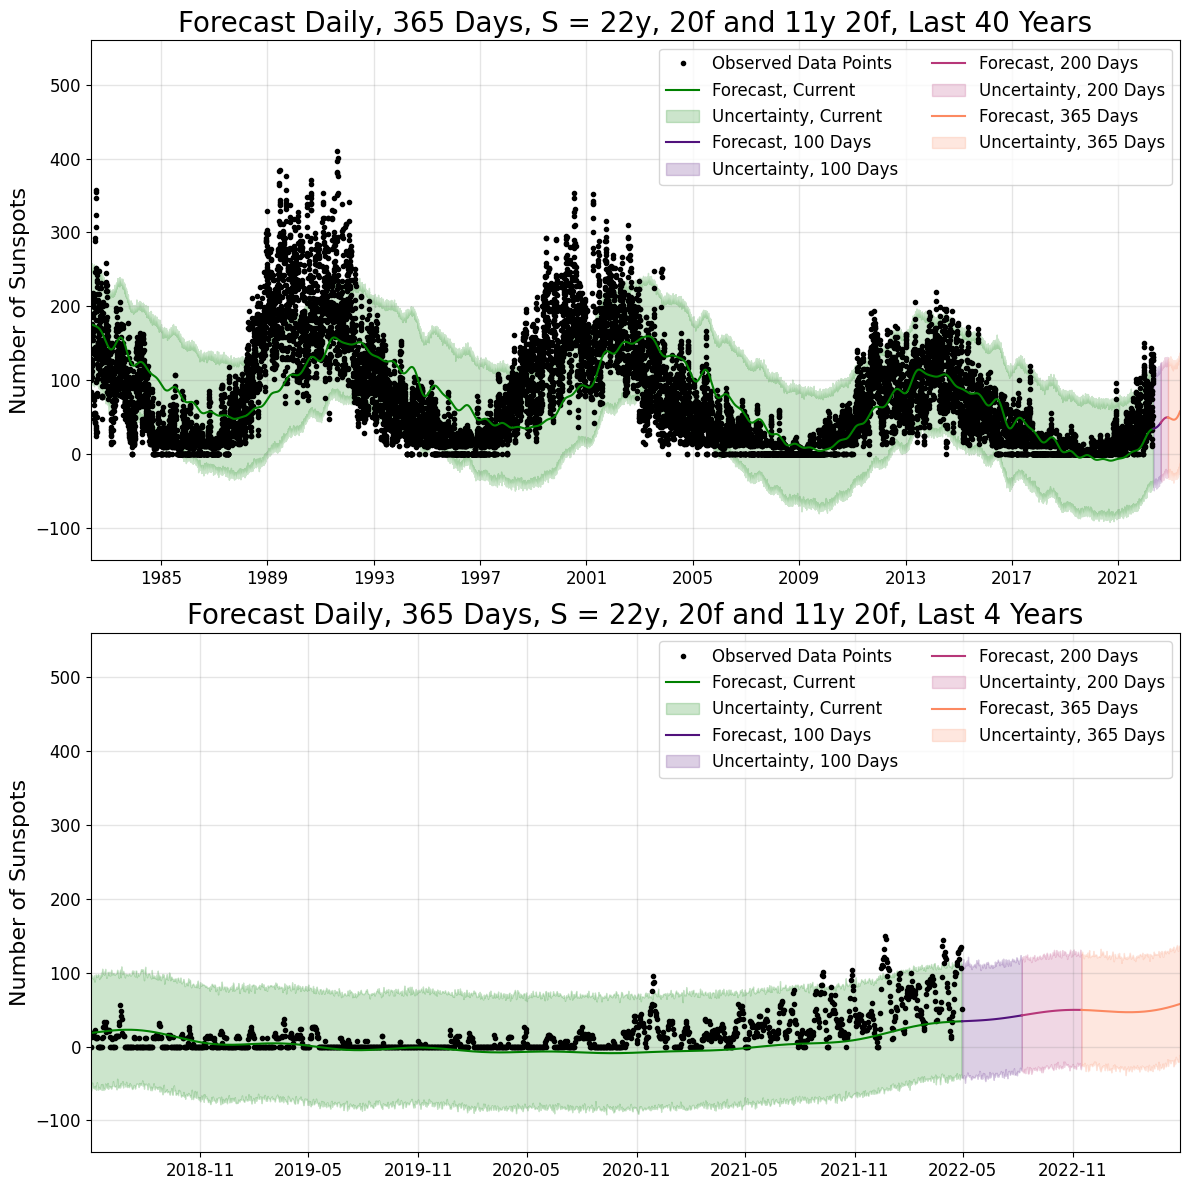

In [20]:
# Plot double seasonality predictions
idx = -1

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, S = 22y, 20f and 11y 20f, Last 40 Years',
        'Forecast Daily, 365 Days, S = 22y, 20f and 11y 20f, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

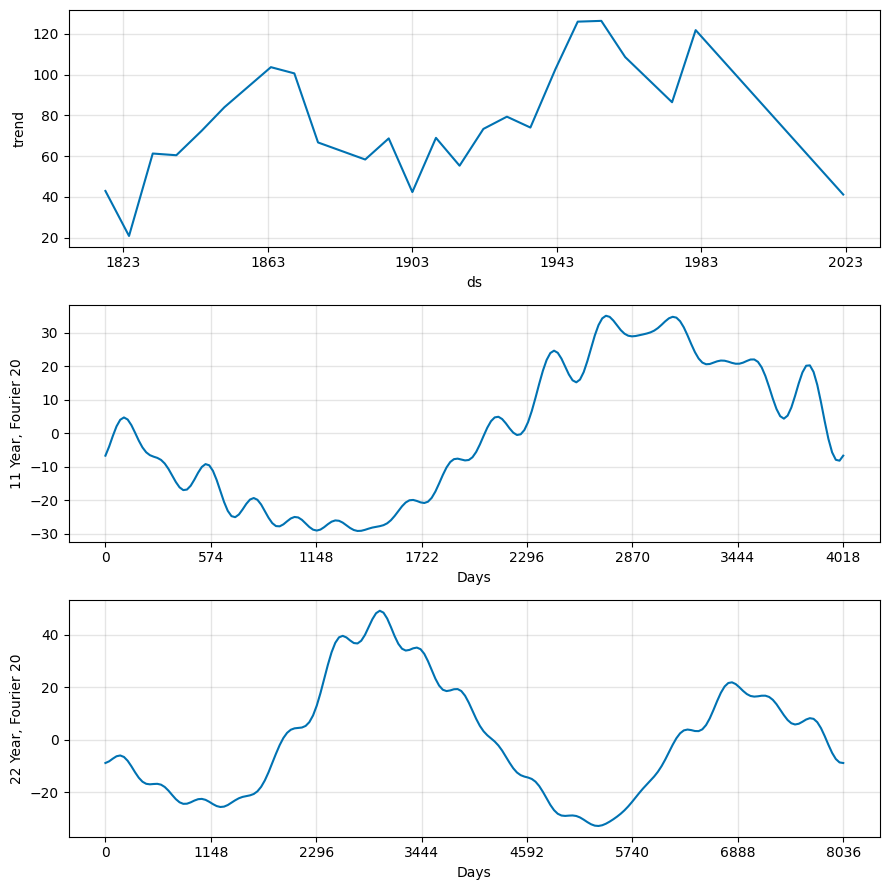

In [21]:
# Components of double seasonality predictions
models[idx].plot_components(forecasts[idx][0], uncertainty = False);

## Tuning Forecasting Growth Type

### Logistic Growth

Logistic Growth requires an upper-bound (a carrying capacity or cap) to place on data in order to model using the assumption that a "population" cannot grow beyond a certain capacity. Thus, it is necessary to modify the input dataframe.

In [22]:
# The maximum value in the dataset is 528, and based on observations of the entire dataset
# 600 seems like a reasonable capacity for the number of daily sunspots
periodic_df.max()

ds    2022-04-30 00:00:00
y                     528
dtype: object

In [23]:
# Training the data using logistic growth
cap = 600
periodic_with_cap = periodic_df.copy()
periodic_with_cap['cap'] = cap

model_name = 'daily__s-11y20f__g-logistic__cp-5__cn-25'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_with_cap, 'func': Prophet}
func_params = {'weekly_seasonality': False, 'yearly_seasonality': False,
               'growth': 'logistic', 'uncertainty_samples': 200}
seasonality_params = {'11 Year, Fourier 20': {'period': 4017.75, 'fourier_order': 20}}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': cap}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

### Flat Growth

The flat growth type is used when there is a strong seasonality in the data rather than meaningful trend changes.

In [24]:
# Training the data using flat growth
model_name = 'daily__s-11y20f__g-flat__cp-5__cn-25'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_with_cap, 'func': Prophet}
func_params = {'weekly_seasonality': False, 'yearly_seasonality': False, 'growth': 'flat'}
seasonality_params = {'11 Year, Fourier 20': {'period': 4017.75, 'fourier_order': 20}}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

### Comparing Growth Types

In [25]:
# Define model names and paths
growth_types = ['linear', 'logistic', 'flat']
model_names = [f'daily__s-11y20f__g-{x}__cp-5__cn-25' for x in growth_types]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]

# Load in linear, logistic, and flat models and forecasts
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]

Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-logistic__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-flat__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-logistic__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-flat__cp-5__cn-25.pickle loaded successfully.


The Logistic and Flat growth models both underperform compared to the linear growth models. This makes sense, as sunspots are not defined by a logistic growth such as population growth, ruling out logistic growth as a reasonable model. It is a little surprising how poorly the flat growth model performs, as the data seems very dominated by seasonality at a glance. Sunspots are, however, physical phenomena that tend to chain together - fluctuations in the magnetic field of the sun cause sunspots which should mean that each fluctuation has an effect on the total amount of sunspots that occur, which means that sunspots are probably not entirely ruled by seasonality as suggested by a flat growth model.

In [26]:
obs_preds_names = [(periodic_df, forecasts[i][0],
                    f'{growth_types[i].title()} Growth')
                   for i in range(len(forecasts))]
ev.multi_model_errors(obs_preds_names)

mae      mape        r2
Linear Growth    45.423222  0.848183  0.407485
Logistic Growth  46.429176  0.860352  0.379692
Flat Growth      49.067191  0.830882  0.290327

The logistic model appears to be slightly dampening the growth of the predictions, leading to further underpredictions compared to the linear model. The flat growth is probably overestimating the number of sunspots since it assumes the data is dictated entirely by its seasonality.

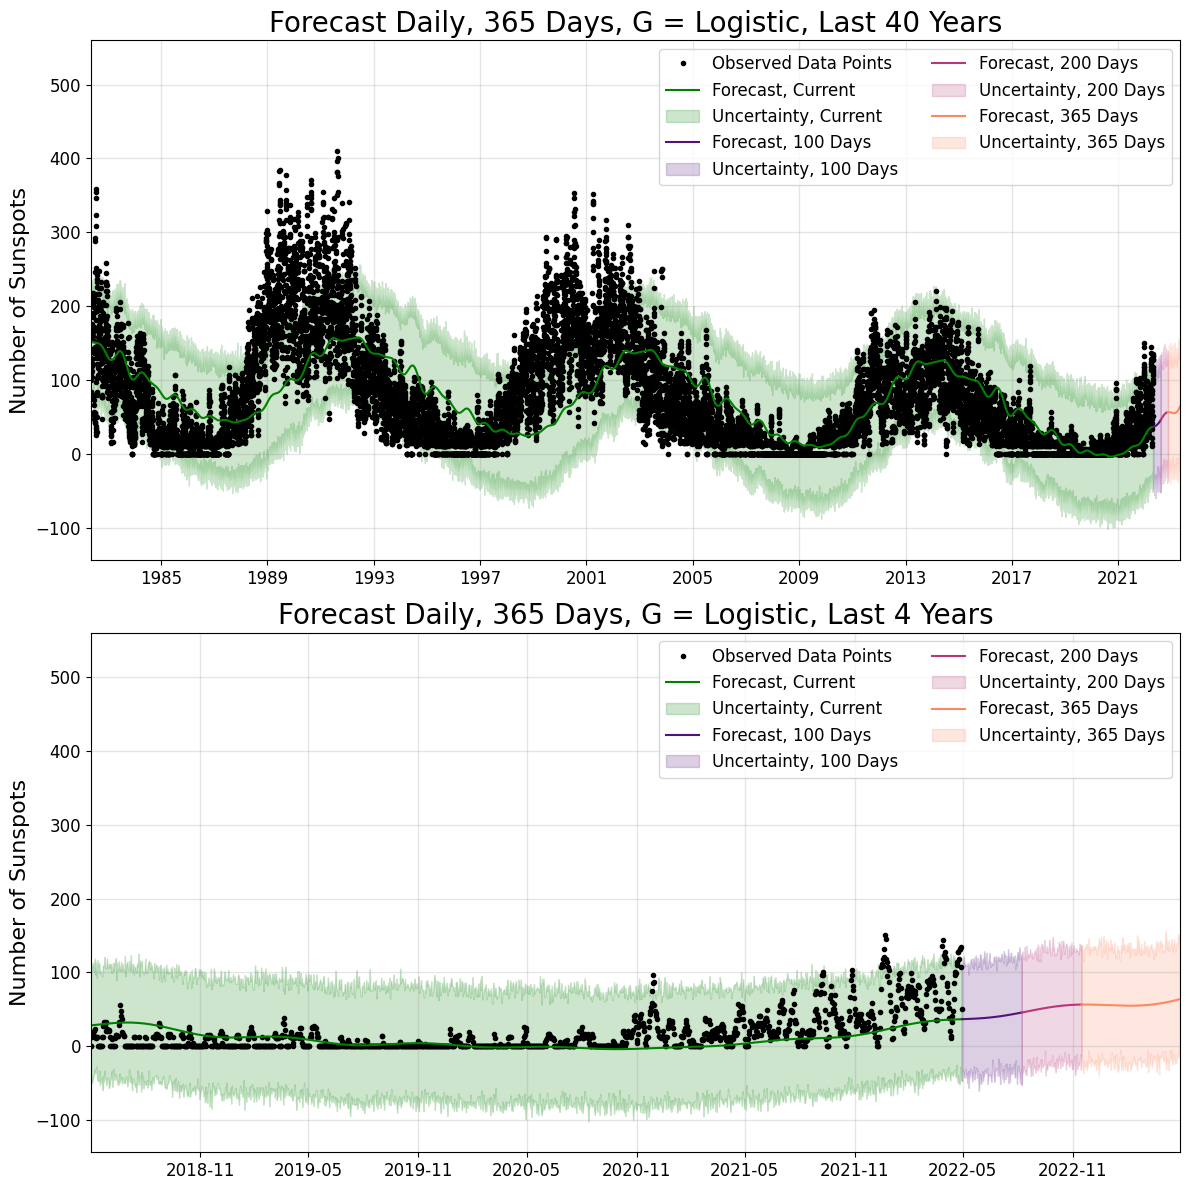

In [27]:
# Plotting logistic growth model predictions
idx = 1

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, G = Logistic, Last 40 Years',
        'Forecast Daily, 365 Days, G = Logistic, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

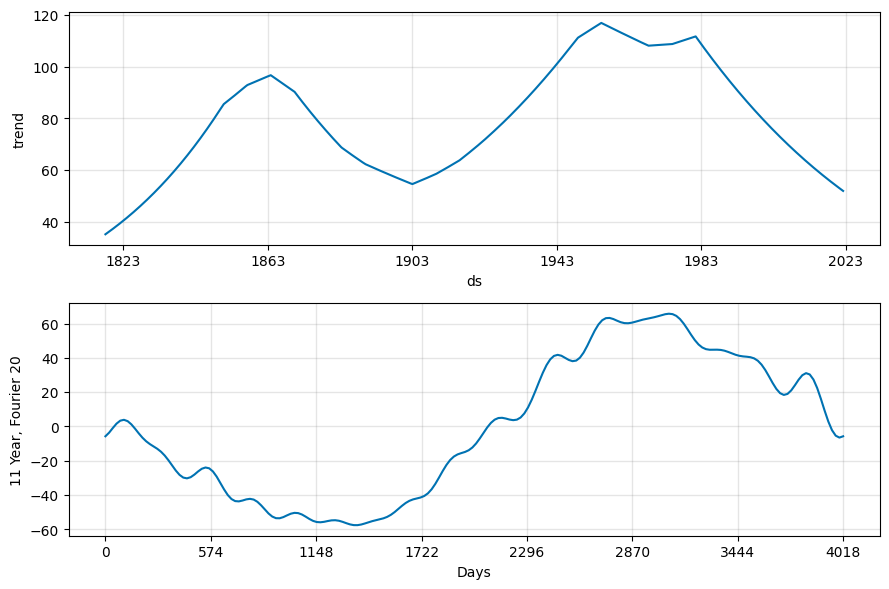

In [28]:
# Looking at logistic growth trend components
models[idx].plot_components(forecasts[idx][0], uncertainty = False, plot_cap = False);

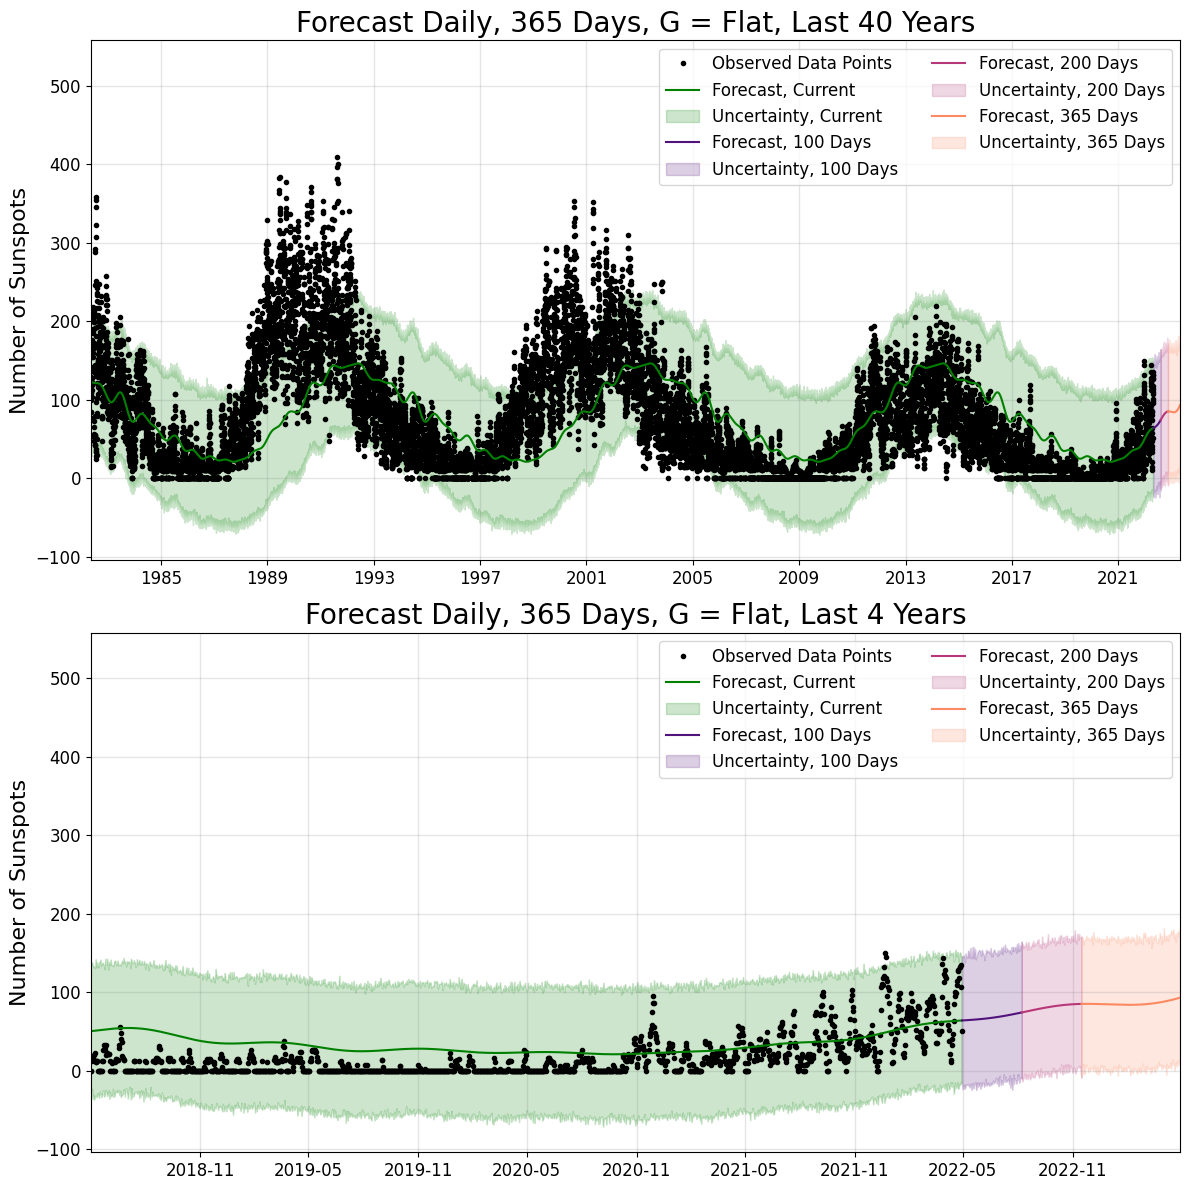

In [29]:
# Plotting flat growth model predictions
idx = 2

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, G = Flat, Last 40 Years',
        'Forecast Daily, 365 Days, G = Flat, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

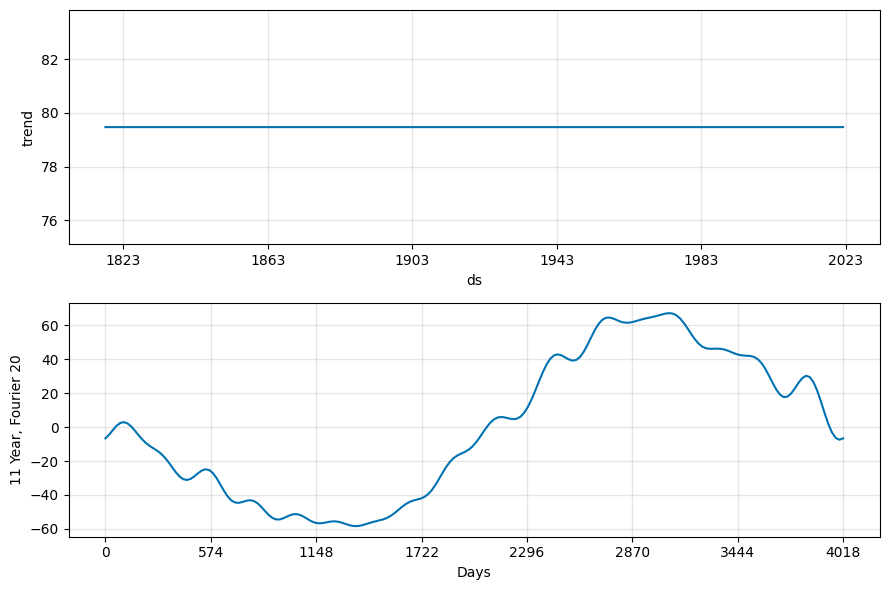

In [30]:
# Looking at flat growth trend components
models[idx].plot_components(forecasts[idx][0], uncertainty = False);

## Tuning Trend Changepoints

### Changepoint Prior Scale

Adjusting the changepoint prior scale allows the trend to be more or less flexible in capturing the data. The default scale is 0.05, with lower values reducing the flexibility and higher values increasing the flexibility of the trend. The current trend for the s-11y20f__g-linear model jumps around a bit, but the model appears to be underfitting quite a bit (~40% $R^2$ value), so the model is probably not complex enough. Values from 0.01 to 0.5 are tested.

In [31]:
# Test on changepoint prior scales of 0.01, 0.02, 0.1, 0.25, 0.5
cp_priors = [0.01, 0.02, 0.1, 0.25, 0.5]
model_names = [f'daily__s-11y20f__g-linear__cp-{int(x * 100)}__cn-25' for x in cp_priors]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
seasonality_params = {'11 Year, Fourier 20': {'period': 4017.75, 'fourier_order': 20}}
base_params = {'df': periodic_df, 'func': Prophet}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     func_params = {'weekly_seasonality': False, 'yearly_seasonality': False,
#                    'changepoint_prior_scale': cp_priors[i]}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

In [32]:
# Load models and forecasts, insert the default CP Prior model into the lists
models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(half_cycle_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(half_cycle_forecast_path))

Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-1__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-2__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-10__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-25__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-1__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-2__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-10__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-25__cn-25.p

Increasing the flexibility of the trend appears to lead to an improvement in model scores, albeit minor. More tuning is needed regarding the number of checkpoints. Allowing the trend to be flexible appears to be a boon, so further models will use a changepoint prior of 0.5.

In [33]:
obs_preds_names = [(periodic_df, forecasts[i][0], f'Changepoint Prior {cp_priors[i - 1]}')
                   for i in range(1, len(forecasts))]
obs_preds_names.insert(2, (periodic_df, forecasts[0][0], f'Changepoint Prior 0.05, Default'))

ev.multi_model_errors(obs_preds_names)

mae      mape        r2
Changepoint Prior 0.01           46.345527  0.860271  0.383087
Changepoint Prior 0.02           46.024259  0.857446  0.392587
Changepoint Prior 0.05, Default  45.423222  0.848183  0.407485
Changepoint Prior 0.1            45.186529  0.842681  0.412626
Changepoint Prior 0.25           45.026466  0.840819  0.415754
Changepoint Prior 0.5            44.994085  0.840676  0.416234

In [34]:
# Plotting cp prior 0.5 predictions
idx = -1

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, CP = 0.5, Last 40 Years',
        'Forecast Daily, 365 Days, CP = 0.5, Last 4 Years'
    ]}

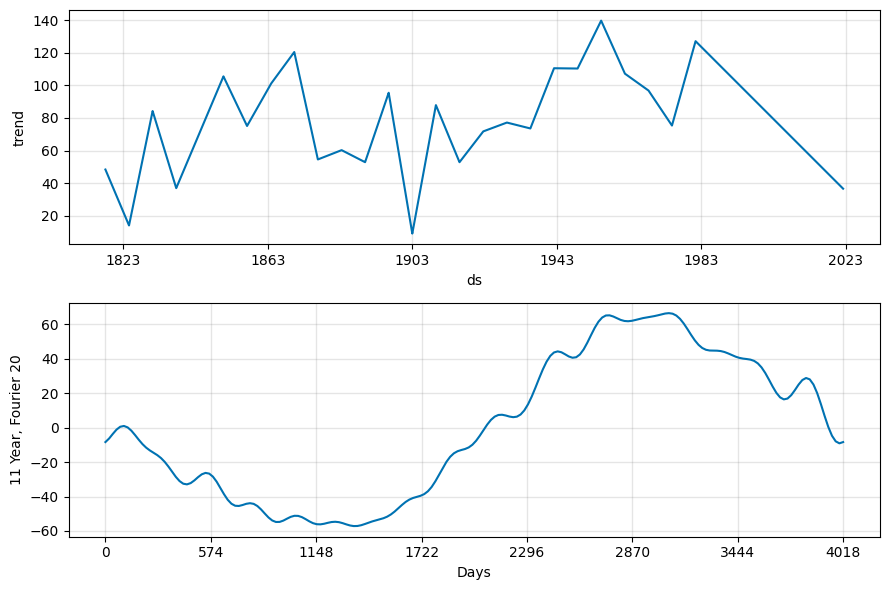

In [35]:
# Looking at cp prior 0.5 trend components
models[idx].plot_components(forecasts[idx][0], uncertainty = False);

### Number of Changepoints

The model has clearly been underfitting, so more changepoints should be used, rather than fewer. Tests are run using 30, 40, 50, 80, and 100 changepoints.

In [36]:
# Test on changepoint numbers 30, 40, 50, 80, 100
cp_num = [30, 40, 50, 80, 100]
model_names = [f'daily__s-11y20f__g-linear__cp-50__cn-{x}' for x in cp_num]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
seasonality_params = {'11 Year, Fourier 20': {'period': 4017.75, 'fourier_order': 20}}
base_params = {'df': periodic_df, 'func': Prophet}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     func_params = {'weekly_seasonality': False, 'yearly_seasonality': False,
#                    'changepoint_prior_scale': 0.5, 'n_changepoints': cp_num[i]}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

In [37]:
# Define base CN number model path
cn_25_name = 'daily__s-11y20f__g-linear__cp-50__cn-25'
cn_25_model_path = os.path.join(models_base_path, cn_25_name + '.pickle')
cn_25_forecast_path = os.path.join(forecasts_base_path, cn_25_name + '.pickle')

# Load models and forecasts and load in default CN number model
models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(cn_25_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(cn_25_forecast_path))

Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-30.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-40.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-50.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-80.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-100.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__cn-30.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__cn-40.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__cn-50.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__c

The error continues to reduce until the number of changepoints passes 80. Allowing more changepoints allows the trend to be much more flexible, but after a certain point, the trend is overly capturing noise.

In [38]:
obs_preds_names = [(periodic_df, forecasts[i][0], f'Changepoint Number {cp_num[i - 1]}')
                   for i in range(1, len(forecasts))]
obs_preds_names.insert(0, (periodic_df, forecasts[0][0], f'Changepoint Number 25, Default'))

ev.multi_model_errors(obs_preds_names)

mae      mape        r2
Changepoint Number 25, Default  44.994085  0.840676  0.416234
Changepoint Number 30           43.965176  0.809760  0.439372
Changepoint Number 40           39.102435  0.708302  0.538087
Changepoint Number 50           37.090254  0.666510  0.578812
Changepoint Number 80           34.964004  0.621157  0.613232
Changepoint Number 100          35.152706  0.621543  0.610713

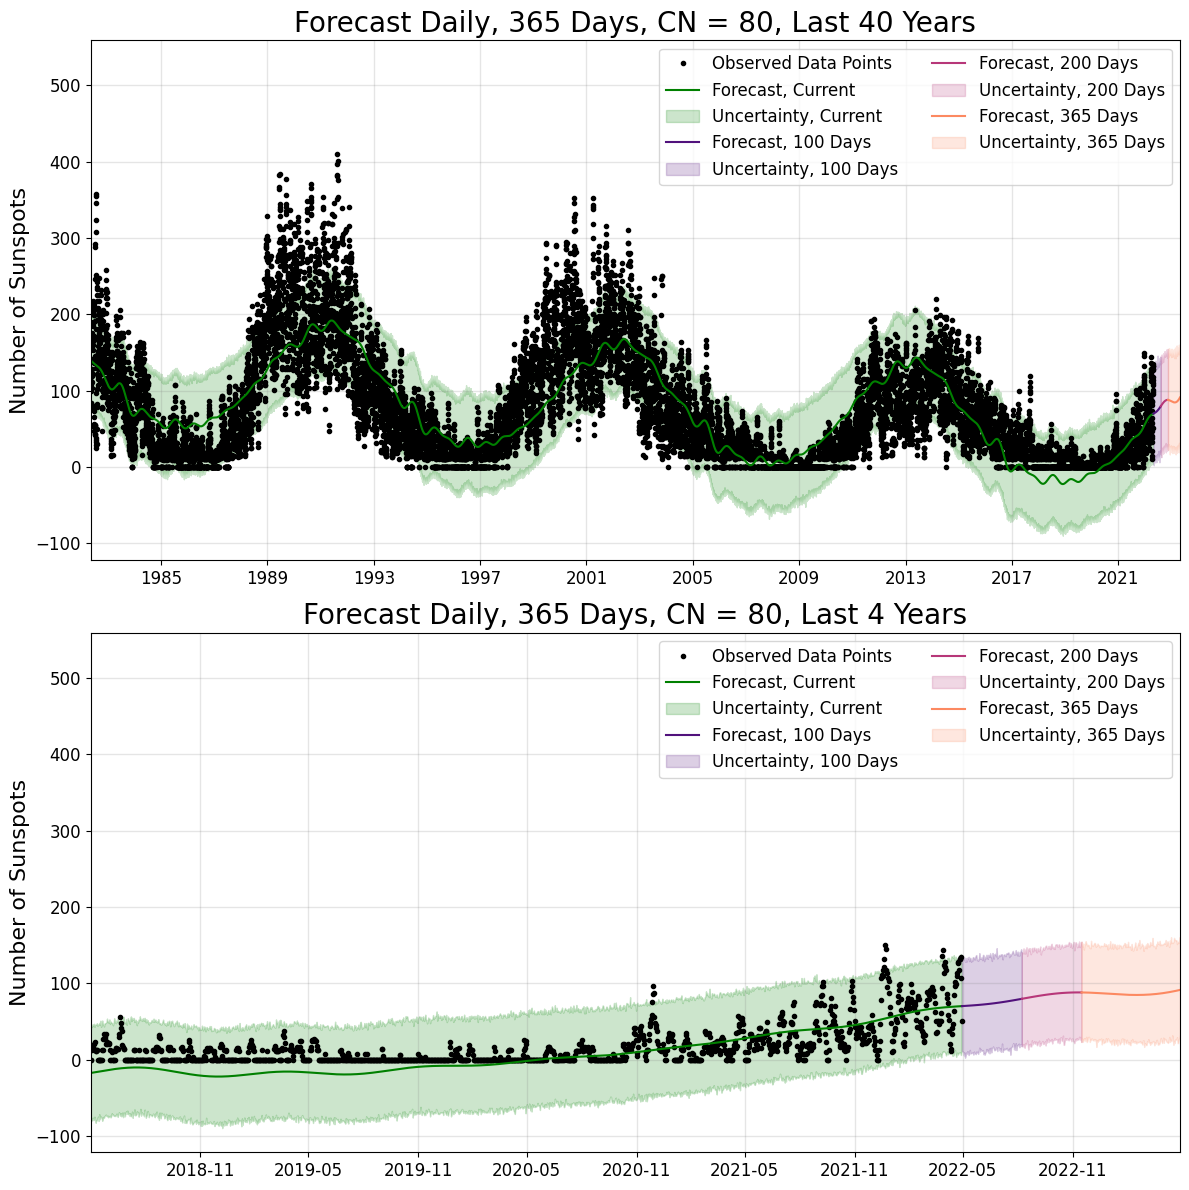

In [39]:
# Plotting cp number 80 predictions
idx = -2

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Daily, 365 Days, CN = 80, Last 40 Years',
        'Forecast Daily, 365 Days, CN = 80, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

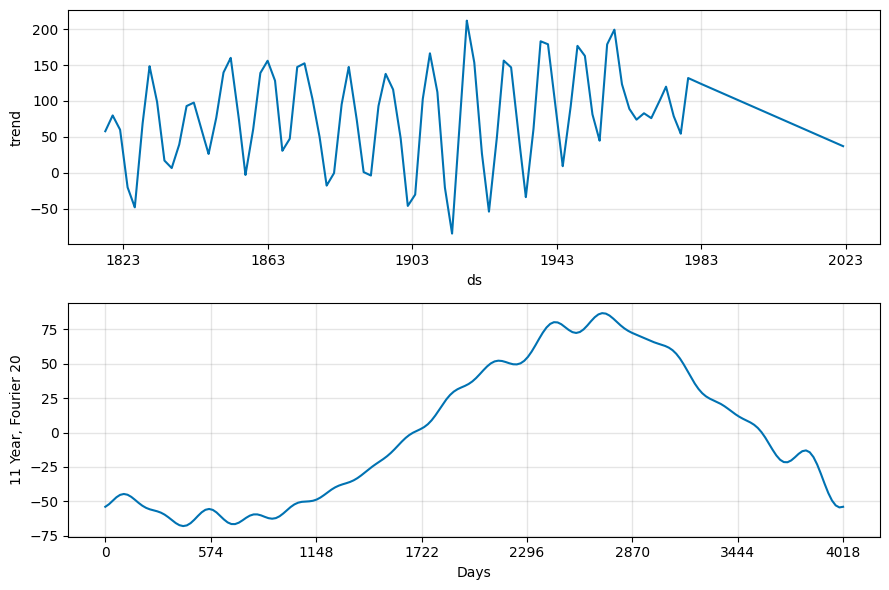

In [40]:
# Looking at cp number 80 predictions
models[idx].plot_components(forecasts[idx][0], uncertainty = False);

## Comparing Different Tuning Steps of Models

In [41]:
# Load the best models and forecasts for each step of the tuning process
model_names = [
    'base_daily', 'daily__s-11y120f__g-linear__cp-5__cn-25',
    'daily__s-11y20f__g-linear__cp-5__cn-25', 'daily__s-11y20f__g-linear__cp-50__cn-25',
    'daily__s-11y20f__g-linear__cp-50__cn-80'
]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]

Pickled object at ../models/daily/base_daily.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y120f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-25.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-80.pickle loaded successfully.
Pickled object at ../forecasts/daily/base_daily.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y120f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__cn-80.pickle loaded successfully.


Although there are many more parameters that can be tuned for the Prophet model, simply by changing three different parameters (1 custom seasonality, increasing the checkpoint prior flexibility from 0.05 to 0.5, and increasing the number of checkpoints from 25 to 80), it is possible to achieve much improved results.

Adding in the domain-knowledge seasonality gave a huge boost to the strength of the model, increasing its $R^2$ score from 0.1449 to 0.4074. Small improvements can be gained by increasing the Fourier order of the custom seasonality; however, the benefits are marginal while adding a large amount of complexity and fit time to the model. Changing the flexibility and number of changepoints is far more effective, and produced a further increase in $R^2$ from 0.4074 to 0.6132. MAE fell by 21.8 (a 38.4% reduction), while MAPE fell by 0.51 (a 45.1% reduction), showing remarkable improvement over the base untuned model.

Further tuning can be done on the currently selected parameters to try to obtain marginal increases in performance. It may be more useful instead to test curated changepoint location selection or by increasing the changepoint range. Care must be taken to not force the model to overfit on the data. It may be difficult to attain higher performance on the daily sampled data due to the noisiness of the data at this sampling frequency.

In [42]:
# Compare model metrics
model_titles = [
    'Base Untuned, G = Linear, CP = 0.05, CN = 25',
    'Seasonality-Tuned, S = 11y, 120f, G = Linear, CP = 0.05, CN = 25',
    'Seasonality_Tuned, S = 11y, 20f, G = Linear, CP = 0.05, CN = 25',
    'Changepoint Prior Tuned, S = 11y, 20f, G = Linear, CP = 0.5, CN = 25',
    'Changepoint Number Tuned, S = 11y, 20f, G = Linear, CP = 0.5, CN = 80'
]
obs_preds_names = [(periodic_df, forecasts[i][0], model_titles[i]) for i in range(len(forecasts))]

ev.multi_model_errors(obs_preds_names)

mae      mape  \
Base Untuned, G = Linear, CP = 0.05, CN = 25        56.713345  1.132964   
Seasonality-Tuned, S = 11y, 120f, G = Linear, C...  45.279609  0.846332   
Seasonality_Tuned, S = 11y, 20f, G = Linear, CP...  45.423222  0.848183   
Changepoint Prior Tuned, S = 11y, 20f, G = Line...  44.994085  0.840676   
Changepoint Number Tuned, S = 11y, 20f, G = Lin...  34.964004  0.621157   

                                                          r2  
Base Untuned, G = Linear, CP = 0.05, CN = 25        0.149900  
Seasonality-Tuned, S = 11y, 120f, G = Linear, C...  0.411943  
Seasonality_Tuned, S = 11y, 20f, G = Linear, CP...  0.407485  
Changepoint Prior Tuned, S = 11y, 20f, G = Line...  0.416234  
Changepoint Number Tuned, S = 11y, 20f, G = Lin...  0.613232

As can be clearly seen, the base untuned model is too simplistic and biased. It is unable to capture essentially any of the shape of the data. Adding in the 11 year seasonality has the effect of capturing the correct shape of the data; however, it appears to lag behind the data, while also failing to capture the highest peaks of the data. Modifying the changepoint number allows the trend to be flexible enough to correct this lagging issue.

All of the models struggle to capture the magnitude of the data's modulation for older sunspot cycles. This may not be relevant, as the number of sunspots recorded during each cycle appears to be trending downwards, and the models seem to be capturing this trend quite well. Even though the models have some errors due to poor fitting on older data, it seems likely that the final tuned model is fairly accurate for current data and would be useful for predicting near-future sunspot occurrences.

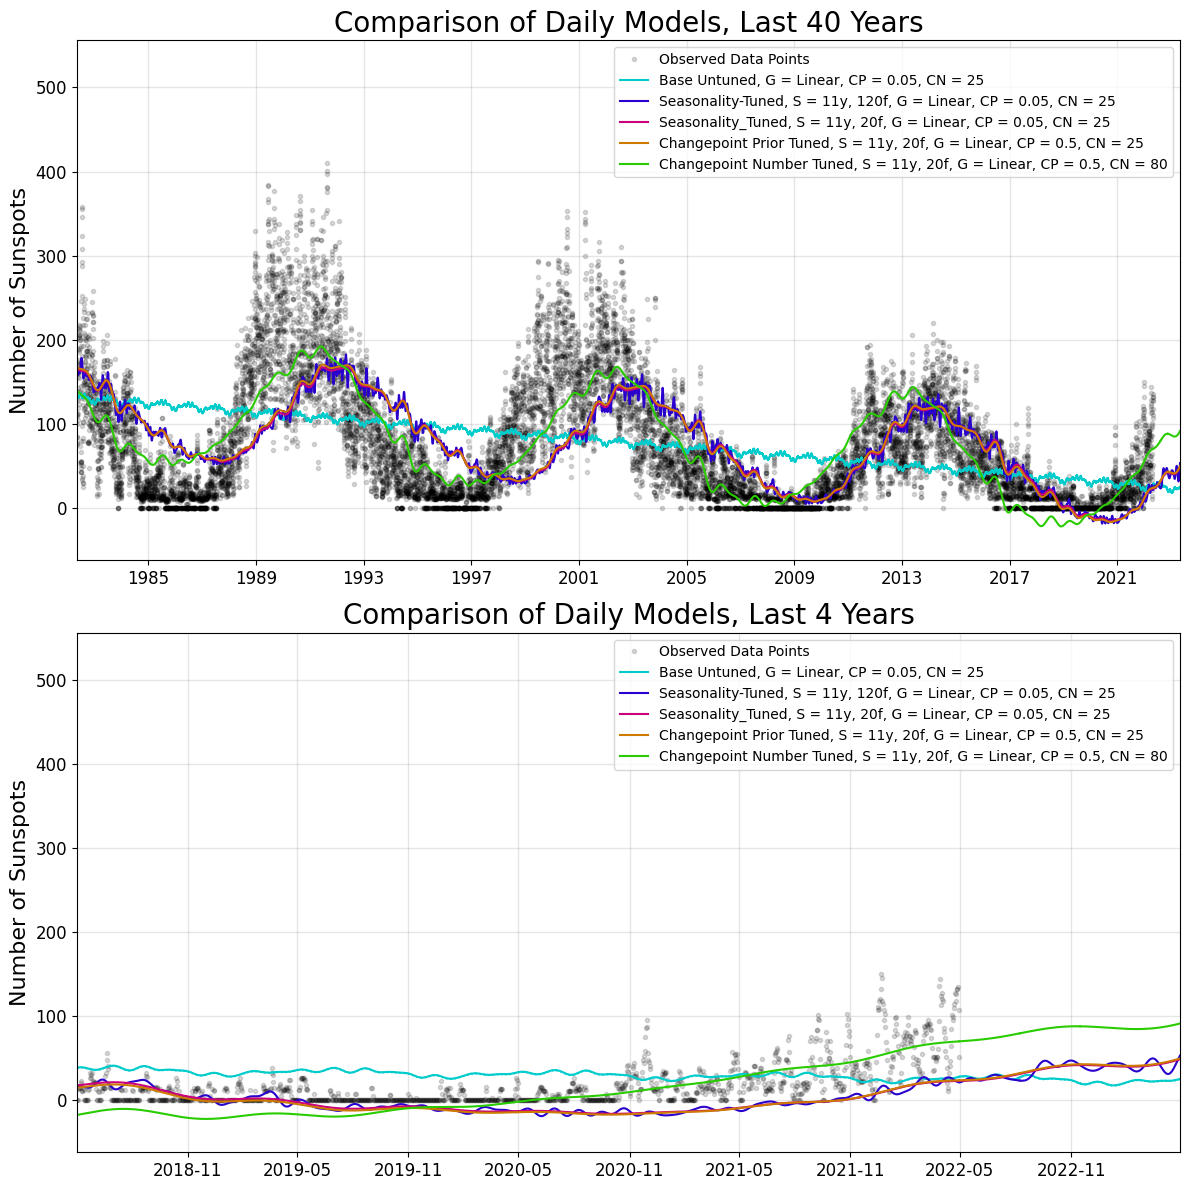

In [43]:
# Compare model predictions
plot_params = {
    'models': models, 'model_names': model_titles, 'forecasts': forecasts,
    'prior_periods': [40 * 365, 4 * 365], 'prediction_periods': future_periods,
    'titles': [
        'Comparison of Daily Models, Last 40 Years',
        'Comparison of Daily Models, Last 4 Years'
    ]}

ev.plot_model_comparisons(**plot_params);